# Homework Assignment  6

**Question 1:** Construct a sentiment classifier using 80% of the reviews in the [Amazon Fine Food Reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews).
The classifier needs to predict if a product got a one-star or a five-star review. 
Evaluate the classifier using the rest of the data (30pt). 


In [1]:
!pip install afinn
!pip install turicreate

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53452 sha256=152d0de12a0d45d4a09b9d55172c2b4ed101b3887847752ab70d85761ef287a8
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn
     |████████████████████████████████| 91.8MB 62kB/s 
     |████████████████████████████████| 327kB 42.2MB/s 
     |████████████████████████████████| 86.3MB 64kB/s 
     |████████████████████████████████| 3.4MB 39.7MB/s 
     |████████████████████████████████| 3.8MB 37.7MB/s 
     |████████████████████████████████| 450kB 38.3MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320850 sha256=5e7b8820c51fc68083cf6a165ba5be3d172702c205118df46121aacb3569a8e2
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=754

In [2]:
!mkdir /root/.kaggle/
import json
import os

# Installing the Kaggle package
!pip install kaggle 
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

!mkdir ./datasets
!mkdir ./datasets/food-reviews
!kaggle datasets download snap/amazon-fine-food-reviews -p ./datasets/
!unzip ./datasets/amazon-fine-food-reviews.zip -d ./datasets/food-reviews/

 99% 239M/242M [00:02<00:00, 145MB/s]
100% 242M/242M [00:02<00:00, 120MB/s]
Archive:  ./datasets/amazon-fine-food-reviews.zip
  inflating: ./datasets/food-reviews/Reviews.csv  
  inflating: ./datasets/food-reviews/database.sqlite  
  inflating: ./datasets/food-reviews/hashes.txt  


Distribution of reviews score from the origin dataset.

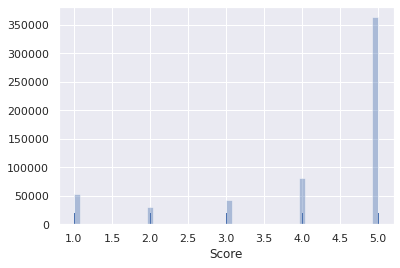

In [12]:
import seaborn as sns
sns.set()
sns.distplot(reviews_df['Score'], kde=False, rug=True)

I randomly selected 5000 reviews from each score (1 and 5) from the original dataset, from two reasons: 1. to make sure that colab won't crash during the evaluation. 2. Since the dataset is unbalanced (I took the same amount of samples from the positive label and from the negative label)

In [2]:
import pandas as pd

reviews_df = pd.read_csv('./datasets/food-reviews/Reviews.csv')
reviews_scores_to_keep = [1,5]
reviews_df_filtered = reviews_df[reviews_df['Score'].isin(reviews_scores_to_keep)]
# randomly select 5000 samples from each label
pos_samples = reviews_df_filtered[reviews_df_filtered['Score']==5].sample(n=5000)
neg_samples = reviews_df_filtered[reviews_df_filtered['Score']==1].sample(n=5000)
reviews_df_filtered = pd.concat([pos_samples, neg_samples], axis=0, sort=False)
print(reviews_df_filtered.shape)
reviews_df_filtered.head(10)

(10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
28934,28935,B0000VM8Y0,A30OJ5EDH7QQJG,BAkins,1,1,5,1310169600,Great product!,Love the clear vanilla flavoring for making wh...
330498,330499,B00022F2A4,A15XPSV4VTY8HV,"leenbean ""leenbean""",23,24,5,1195516800,Great for Gluten Free,This is a great product for making gluten free...
65788,65789,B0007A0AQW,A1REPQGT1N651L,Vanessa,0,0,5,1345507200,Great for potty training!!,I adopted a 1 year old Yorkie rescue pup who i...
137819,137820,B0000YVCFS,A2YP1QI0BUC1U0,"A. Loomis ""AL""",1,1,5,1123891200,Wonderful product! I love the Wild Rasberry F...,"I am a person with Crohns disease, & I can not..."
163710,163711,B002ZJTX16,A1QBVUCTWP9XR4,Linda Haptonstall,0,0,5,1221523200,Good snacks,Such an easy way to buy calorie controlled sna...
389028,389029,B004T9XDFM,A3J23DX3RGRZUC,Rebecca Pizzitola,1,1,5,1331856000,"Great ""Adult"" Dessert","At first bite, the dusting makes these guys a ..."
453966,453967,B004I5MAAQ,A3NA304NMYYSME,Belinda Boulter,0,0,5,1315526400,Great pasta texture,"These noodles have a great, chewy pasta textur..."
93141,93142,B004YV80OE,A37PZJH2F13IOR,"J. Rose ""JR From the Ball so Blue""",0,0,5,1319068800,Convenience food that's delicious,I added chunked fresh chicken breast to this i...
507088,507089,B000H154US,ARR275B124553,Mountainwizard,0,0,5,1345852800,Gluten Free doesn't have to hurt!,I have always been a cracker and cheese junkie...
200005,200006,B0046H312W,A2BDFFGAE6O868,Kathy,1,1,5,1315094400,Best Chicken Stock Ever!,"This IS the best chicken stock ever, but here'..."


In [0]:
def score2sentiment(label):
    if label == 5:
        return 1
    else:
        return 0

reviews_df_filtered['sentiment'] = reviews_df_filtered['Score'].apply(lambda label: score2sentiment(label))
reviews_df_filtered['all_text'] = reviews_df_filtered['Summary']+" "+reviews_df_filtered['Text']


I combined the Summary of the review with it's full text, Also I normalize the combined text and removed stop words and lowered the tokens. I used classifier with Bag of words features.

In [17]:
import nltk
import turicreate as tc
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

stop_words_set = set(stopwords.words("english"))

def normalize_text(text):
  text = text.lower()
  words_list = word_tokenize(text)
  l = [w for w in words_list if w not in stop_words_set]
  return " ".join(l)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
reviews_df_filtered.dropna(subset=['all_text'], inplace=True) 
reviews_df_filtered['normalize_all_text'] = reviews_df_filtered['all_text'].apply(lambda x: normalize_text(x))

reviews_sf = tc.SFrame(data=reviews_df_filtered[['normalize_all_text', 'sentiment']])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
test, train  = reviews_sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )

Train size 7995
Test size: 2005


In [24]:
train['words_dict'] = tc.text_analytics.count_words(train['normalize_all_text'])
train.materialize()

test['words_dict'] = tc.text_analytics.count_words(test['normalize_all_text'])
test.materialize()

features_list = ['words_dict']
words_cls = tc.classifier.create(train,features=features_list, target="sentiment")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 18800

Number of coefficients      : 18801

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.061169     | 0.945095          | 0.827500            |

| 1         | 4        | 1.000000  | 0.114233     | 0.960500          | 0.845000            |

| 2         | 6        | 0.771105  | 0.170207     | 0.984463          | 0.872500            |

| 3         | 8        | 0.771105  | 0.219773     | 0.993153          | 0.875000            |

| 4         | 9        | 0.963882  | 0.255253     | 0.997367          | 0.875000            |

| 9         | 15       | 1.000000  | 0.419372     | 1.000000          | 0.872500            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 18800

Number of coefficients    : 18801

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.060037     | 0.945095          | 0.827500            |

| 1         | 4        | 1.000000  | 0.102509     | 0.972745          | 0.865000            |

| 2         | 6        | 0.783997  | 0.144412     | 0.985517          | 0.870000            |

| 3         | 7        | 0.979996  | 0.177575     | 0.992758          | 0.872500            |

| 4         | 8        | 1.000000  | 0.210455     | 0.995523          | 0.875000            |

| 9         | 13       | 1.000000  | 0.347740     | 0.999342          | 0.852500            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.8725
PROGRESS: SVMClassifier                   : 0.8525
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [25]:
words_results = words_cls.evaluate(test)
words_results

{'accuracy': 0.9057356608478803,
 'auc': 0.9563971884689025,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |  920  |
 |      1       |        0        |  105  |
 |      1       |        1        |  896  |
 |      0       |        1        |   84  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9045936395759717,
 'log_loss': 0.422555172038779,
 'precision': 0.9142857142857143,
 'recall': 0.8951048951048951,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------------------+-------------------+------+------+
 | threshold |        fpr         |        tpr        |  p   |  n   |
 +-----------+--------------------+-------------------+------+------+
 |    0.0    | 

**Question 2:** Construct a sentiment classifier using features from the [TextBlob package](https://textblob.readthedocs.io/en/dev/index.html),
    and from the [affin package](https://pypi.org/project/afinn/). Compare the two classifiers results and visualize it (however you want) (20pt)

In [11]:
!pip install textblob

Lets create classifier with all sentiment features

In [38]:
import nltk
nltk.download('movie_reviews')
from textblob import TextBlob
from afinn import Afinn

def get_textblob_features(text):
  blob = TextBlob(text)
  sentiment = blob.sentiment
  return {'polarity': sentiment.polarity, 'subjectivity':sentiment.subjectivity}

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [13]:
def get_sentiment_features(train, test):
  afinn_text = Afinn()
  train['afinn_score_text'] = train['normalize_all_text'].apply(lambda t: afinn_text.score(t))
  test['afinn_score_text'] = test['normalize_all_text'].apply(lambda t: afinn_text.score(t))
  train['textblob_score_text'] = train['normalize_all_text'].apply(lambda t: get_textblob_features(t))
  test['textblob_score_text'] = test['normalize_all_text'].apply(lambda t: get_textblob_features(t))
  return train, test

# hold only required feild
train_sentiment = train[['normalize_all_text', 'sentiment']].to_dataframe()
test_sentiment = test[['normalize_all_text', 'sentiment']].to_dataframe()
train_sentiment, test_sentiment = get_sentiment_features(train_sentiment, test_sentiment)


features_list = ['afinn_score_text', 'textblob_score_text']
cls_all_sentiment_features = tc.classifier.create(tc.SFrame(data=train_sentiment),features=features_list, target="sentiment")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 3

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.009671     | 0.842528          | 0.832500            | 0.555134          | 0.555330            |

| 2         | 0.020497     | 0.842923          | 0.850000            | 0.479104          | 0.479839            |

| 3         | 0.027574     | 0.846741          | 0.840000            | 0.431708          | 0.435038            |

| 4         | 0.034876     | 0.847400          | 0.842500            | 0.400845          | 0.409055            |

| 5         | 0.042372     | 0.850691          | 0.850000            | 0.380224          | 0.390706            |

| 10        | 0.077759     | 0.854641          | 0.847500            | 0.336361          | 0.368459            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 3

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.008822     | 0.836603          | 0.825000            | 0.400316          | 0.403814            |

| 2         | 0.016101     | 0.838710          | 0.825000            | 0.403133          | 0.411227            |

| 3         | 0.023674     | 0.834365          | 0.812500            | 0.407000          | 0.418744            |

| 4         | 0.030552     | 0.843581          | 0.817500            | 0.404476          | 0.409824            |

| 5         | 0.037961     | 0.843055          | 0.830000            | 0.405217          | 0.409813            |

| 10        | 0.074360     | 0.841606          | 0.827500            | 0.404746          | 0.409980            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 3

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.009413     | 0.842528          | 0.832500            | 0.393439          | 0.397539            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 3

Number of coefficients    : 4

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.022981     | 0.711389          | 0.722500            |

| 1         | 4        | 1.000000  | 0.035879     | 0.792495          | 0.795000            |

| 2         | 6        | 0.891037  | 0.044410     | 0.816722          | 0.817500            |

| 3         | 8        | 0.891037  | 0.057651     | 0.821198          | 0.842500            |

| 4         | 9        | 1.000000  | 0.064222     | 0.820671          | 0.837500            |

| 9         | 14       | 1.000000  | 0.090332     | 0.823700          | 0.832500            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 2

Number of unpacked features : 3

Number of coefficients      : 4

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.017753     | 0.823173          | 0.845000            |

| 2         | 3        | 0.030301     | 0.821593          | 0.835000            |

| 3         | 4        | 0.044086     | 0.823305          | 0.835000            |

| 4         | 5        | 0.057674     | 0.823568          | 0.835000            |

| 5         | 6        | 0.070021     | 0.823568          | 0.835000            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.8475
PROGRESS: RandomForestClassifier          : 0.8275
PROGRESS: DecisionTreeClassifier          : 0.83
PROGRESS: SVMClassifier                   : 0.8325
PROGRESS: LogisticClassifier              : 0.835
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [16]:
all_sentiment_results = cls_all_sentiment_features.evaluate(tc.SFrame(data=test_sentiment))
all_sentiment_results

{'accuracy': 0.8244389027431421,
 'auc': 0.8989183127629337,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |  814  |
 |      1       |        0        |  162  |
 |      1       |        1        |  839  |
 |      0       |        1        |  190  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.8266009852216749,
 'log_loss': 0.40290339252326707,
 'precision': 0.815354713313897,
 'recall': 0.8381618381618382,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1001 | 1004 |
 |   1e-05   | 1.0 | 1.0 | 1001 | 1004 |
 |   2e-05   | 1.0 

Lets check which sentiment features perform better on our dataset, first we will examine the Afinn sentiment feature

In [17]:
features_list = ['afinn_score_text']
cls_only_afinn_sentiment_feature = tc.classifier.create(tc.SFrame(data=train_sentiment),features=features_list, target="sentiment")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.011676     | 0.792627          | 0.787500            | 0.589683          | 0.592802            |

| 2         | 0.017822     | 0.792627          | 0.787500            | 0.534926          | 0.540608            |

| 3         | 0.023980     | 0.792495          | 0.790000            | 0.503554          | 0.511070            |

| 4         | 0.029896     | 0.792495          | 0.790000            | 0.484964          | 0.493957            |

| 5         | 0.036427     | 0.792495          | 0.790000            | 0.473779          | 0.484400            |

| 10        | 0.061575     | 0.792495          | 0.790000            | 0.457616          | 0.471378            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.007458     | 0.792627          | 0.787500            | 0.472745          | 0.483437            |

| 2         | 0.012910     | 0.792627          | 0.787500            | 0.472899          | 0.482792            |

| 3         | 0.017877     | 0.792627          | 0.787500            | 0.472847          | 0.483796            |

| 4         | 0.022521     | 0.792495          | 0.790000            | 0.472781          | 0.483039            |

| 5         | 0.028793     | 0.792495          | 0.790000            | 0.472825          | 0.482794            |

| 10        | 0.051289     | 0.792495          | 0.790000            | 0.472783          | 0.483259            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.013557     | 0.792627          | 0.787500            | 0.472883          | 0.484061            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 5.000000  | 0.029944     | 0.727716          | 0.722500            |

| 1         | 6        | 2.500000  | 0.037786     | 0.733246          | 0.735000            |

| 2         | 9        | 1.553215  | 0.044760     | 0.791178          | 0.772500            |

| 3         | 11       | 1.553215  | 0.050236     | 0.791178          | 0.772500            |

| 4         | 13       | 1.231910  | 0.055251     | 0.791178          | 0.772500            |

| 8         | 23       | 0.857298  | 0.076246     | 0.791178          | 0.772500            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients      : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.023683     | 0.771955          | 0.772500            |

| 2         | 3        | 0.032276     | 0.791178          | 0.772500            |

| 3         | 4        | 0.042506     | 0.791178          | 0.772500            |

| 4         | 5        | 0.052339     | 0.791178          | 0.772500            |

| 5         | 6        | 0.061278     | 0.791178          | 0.772500            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.79
PROGRESS: RandomForestClassifier          : 0.79
PROGRESS: DecisionTreeClassifier          : 0.7875
PROGRESS: SVMClassifier                   : 0.7725
PROGRESS: LogisticClassifier              : 0.7725
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [18]:
only_afinn_sentiment_results = cls_only_afinn_sentiment_feature.evaluate(tc.SFrame(data=test_sentiment))
only_afinn_sentiment_results

{'accuracy': 0.8094763092269327,
 'auc': 0.8687990296556033,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |  761  |
 |      1       |        0        |  139  |
 |      1       |        1        |  862  |
 |      0       |        1        |  243  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.818613485280152,
 'log_loss': 0.44580022933945423,
 'precision': 0.7800904977375566,
 'recall': 0.8611388611388612,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1001 | 1004 |
 |   1e-05   | 1.0 | 1.0 | 1001 | 1004 |
 |   2e-05   | 1.0 

Now we will examine the TextBlob sentiment feature

In [19]:
features_list = ['textblob_score_text']
cls_only_textblob_sentiment_feature = tc.classifier.create(tc.SFrame(data=train_sentiment),features=features_list, target="sentiment")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 2

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.011727     | 0.826596          | 0.792500            | 0.567099          | 0.580991            |

| 2         | 0.021022     | 0.827386          | 0.795000            | 0.498642          | 0.518199            |

| 3         | 0.028981     | 0.831468          | 0.795000            | 0.456673          | 0.482834            |

| 4         | 0.036976     | 0.831336          | 0.797500            | 0.430552          | 0.463613            |

| 5         | 0.046261     | 0.830151          | 0.800000            | 0.412941          | 0.451317            |

| 10        | 0.077586     | 0.834628          | 0.797500            | 0.375184          | 0.432322            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 2

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.005711     | 0.589467          | 0.552500            | 0.667436          | 0.689564            |

| 2         | 0.010790     | 0.601580          | 0.587500            | 0.663836          | 0.684748            |

| 3         | 0.016350     | 0.603687          | 0.587500            | 0.663297          | 0.682577            |

| 4         | 0.022978     | 0.603160          | 0.582500            | 0.663128          | 0.684523            |

| 5         | 0.032234     | 0.780250          | 0.737500            | 0.585632          | 0.608127            |

| 10        | 0.058422     | 0.816326          | 0.772500            | 0.552334          | 0.575815            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 2

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.007657     | 0.826596          | 0.792500            | 0.420944          | 0.459552            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 2

Number of coefficients    : 3

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 5.000000  | 0.031367     | 0.710731          | 0.682500            |

| 1         | 7        | 1.250000  | 0.045992     | 0.807637          | 0.797500            |

| 2         | 8        | 1.250000  | 0.055072     | 0.808032          | 0.797500            |

| 3         | 10       | 1.250000  | 0.065416     | 0.810402          | 0.805000            |

| 4         | 13       | 1.167607  | 0.077715     | 0.811060          | 0.802500            |

| 9         | 24       | 1.000000  | 0.112875     | 0.813430          | 0.792500            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 7595

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 2

Number of coefficients      : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.028677     | 0.813957          | 0.815000            |

| 2         | 3        | 0.042416     | 0.814220          | 0.800000            |

| 3         | 4        | 0.054559     | 0.814220          | 0.795000            |

| 4         | 5        | 0.068835     | 0.813430          | 0.795000            |

| 5         | 6        | 0.077028     | 0.813430          | 0.795000            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.7975
PROGRESS: RandomForestClassifier          : 0.7725
PROGRESS: DecisionTreeClassifier          : 0.7925
PROGRESS: SVMClassifier                   : 0.7925
PROGRESS: LogisticClassifier              : 0.795
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [20]:
only_textblob_sentiment_results = cls_only_textblob_sentiment_feature.evaluate(tc.SFrame(data=test_sentiment))
only_textblob_sentiment_results

{'accuracy': 0.7935162094763092,
 'auc': 0.873464682727631,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |  765  |
 |      1       |        0        |  175  |
 |      1       |        1        |  826  |
 |      0       |        1        |  239  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7996127783155856,
 'log_loss': 0.44471897685294287,
 'precision': 0.7755868544600939,
 'recall': 0.8251748251748252,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1001 | 1004 |
 |   1e-05   | 1.0 | 1.0 | 1001 | 1004 |
 |   2e-05   | 1.0 

We can see that Afinn sentiment feature is much better for our dataset, In addition it has even better results when we using both features together. Now let's compare bag of words classifier results to combined classifier with sentiment features (Afinn and TextBlob).

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def plot_roc_curve(results, title):
  plt.plot(results['roc_curve']['fpr'],
          results['roc_curve']['tpr'],
          label='ROC Curve (AUC = %0.5f)' %results['auc'])

  plt.xlim([-0.02, 1.0])
  plt.ylim([0., 1.02])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title(title)
  plt.legend()
  plt.show()

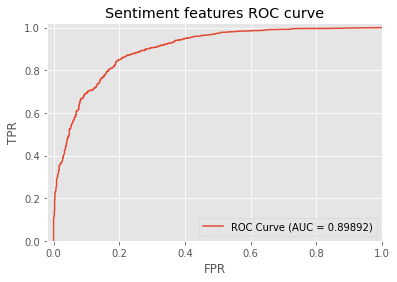

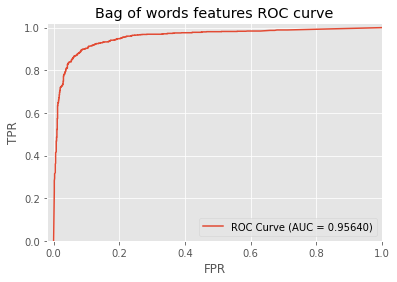

In [26]:
plot_roc_curve(all_sentiment_results, 'Sentiment features ROC curve')
plot_roc_curve(words_results, 'Bag of words features ROC curve')



From previous plots we can see that Bag of words classifier is much better for our dataset. 

**Question 3:**  Select a different reviews dataset and create a sentiment classifier which utilizes word embeddings (25pt).
Evaluate this classifier (5pt). Try to improve your classifier by adding additional features (20pt)

I will use Hotels revious dataset.

In [32]:
import spacy
!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=d5009b4d0562a99a9a840b82b442d76486600aa2321d1a51b0a0d542e6cd420d
  Stored in directory: /tmp/pip-ephem-wheel-cache-wsw3uckt/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
!mkdir ./datasets/hotel-review
# download the dataset from Kaggle and unzip it
!kaggle datasets download anu0012/hotel-review -p ./datasets/hotel-review
!unzip ./datasets/hotel-review/*.zip  -d ./datasets/hotel-review/

 41% 9.00M/21.7M [00:00<00:00, 31.2MB/s]
100% 21.7M/21.7M [00:00<00:00, 49.1MB/s]
Archive:  ./datasets/hotel-review/hotel-review.zip
  inflating: ./datasets/hotel-review/test.csv  
  inflating: ./datasets/hotel-review/train.csv  


In [34]:
import turicreate as tc

def score2sentiment(label):
    if label == 'happy':
        return 1
    else:
        return 0

def get_hotel_reviews_data(data_type):
  sf = tc.SFrame.read_csv("./datasets/hotel-review/{}.csv".format(data_type))  
  if data_type=='train':
    sf = sf.rename({"Is_Response": 'sentiment'})
    sf = sf[sf['sentiment'].apply(lambda s: s=='happy' or s=='not happy')]
    sf['sentiment'] = sf['sentiment'].apply(lambda s: score2sentiment(s))
    sf.materialize()
  return sf

sf = get_hotel_reviews_data('train')

Finished parsing file /content/datasets/hotel-review/train.csv

Parsing completed. Parsed 100 lines in 1.1669 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/hotel-review/train.csv

Parsing completed. Parsed 38932 lines in 0.825348 secs.

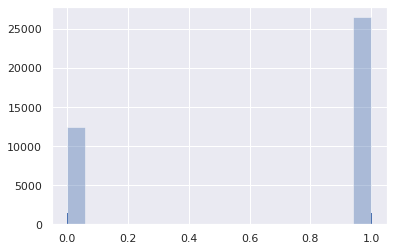

In [25]:
import seaborn as sns
sns.set()
sns.distplot(train_sf['sentiment'], kde=False, rug=True)

I randomly selected 5000 samples from each sentiment label 

In [0]:
import pandas as pd
pos_sf = sf[sf['sentiment'].apply(lambda s: s==1 )]
neg_sf = sf[sf['sentiment'].apply(lambda s: s==0 )]
pos_df = pos_sf.to_dataframe().sample(n=5000)
neg_df = neg_sf.to_dataframe().sample(n=5000)
sf = tc.SFrame(pd.concat([pos_df, neg_df], axis=0, sort=False))
sf['normalize_all_text'] = sf['Description'].apply(lambda x: normalize_text(x))
sf.materialize()

In [36]:
from tqdm import tqdm
import spacy

def get_embedding_features(sf):
  nlp = spacy.load('en_core_web_lg')
  l = []
  for i in tqdm(range(len(sf))):
      text = sf[i]["normalize_all_text"]
      l.append(nlp(text).vector)
  sf['vector'] = l 
  return sf

sf = get_embedding_features(sf)


100%|██████████| 10000/10000 [05:04<00:00, 32.83it/s]


In [0]:
afinn_text = Afinn()
sf['afinn_score_text'] = sf['normalize_all_text'].apply(lambda t: afinn_text.score(t))
sf['textblob_score_text'] = sf['normalize_all_text'].apply(lambda t: get_textblob_features(t))
sf.materialize()
sf['words_2grams'] = tc.text_analytics.count_ngrams(sf['normalize_all_text'], n=2, method='word')
sf.materialize()

In [55]:
features_list = ['vector']
# split to test and train
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
cls_embedding_feature_only = tc.classifier.create(train,features=features_list, target="sentiment")

Train size 8033
Test size: 1967
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 7631

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients      : 301

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 2.935147     | 0.856375          | 0.858209            |

| 2         | 3        | 4.521063     | 0.866204          | 0.865672            |

| 3         | 4        | 6.112881     | 0.867776          | 0.860697            |

| 4         | 5        | 7.683027     | 0.867776          | 0.855721            |

| 5         | 6        | 9.279374     | 0.868038          | 0.855721            |

| 6         | 7        | 10.840677    | 0.868038          | 0.855721            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

SVM:

--------------------------------------------------------

Number of examples          : 7631

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients    : 301

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 0.250000  | 0.565914     | 0.631241          | 0.671642            |

| 1         | 7        | 1.250000  | 1.094183     | 0.734635          | 0.741294            |

| 2         | 14       | 2.697628  | 2.161325     | 0.761892          | 0.756219            |

| 3         | 15       | 2.697628  | 2.429074     | 0.716420          | 0.661692            |

| 4         | 19       | 1.498876  | 3.076539     | 0.787184          | 0.776119            |

| 9         | 29       | 1.155719  | 4.969870     | 0.837636          | 0.840796            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.8557213930348259
PROGRESS: SVMClassifier                   : 0.8407960199004975
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


Lets evaluate our embedding sentiment classifier.

In [56]:
only_embedding_feature_results = cls_embedding_feature_only.evaluate(test)
only_embedding_feature_results

{'accuracy': 0.845958312150483,
 'auc': 0.916062047569804,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  146  |
 |      0       |        0        |  854  |
 |      1       |        0        |  157  |
 |      1       |        1        |  810  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.8424336973478939,
 'log_loss': 0.37838842719941107,
 'precision': 0.8472803347280334,
 'recall': 0.8376421923474664,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-------+-----+-----+------+
 | threshold |  fpr  | tpr |  p  |  n   |
 +-----------+-------+-----+-----+------+
 |    0.0    |  1.0  | 1.0 | 967 | 1000 |
 |   1e-05   | 0.998 | 1.0 | 967 | 1000 |
 |   2e-05   | 

Lets create sentiment classifier with more features like: afinn sentiment score, textblob sentiment score and 2gram.

In [63]:
features_list = ['vector','afinn_score_text', 'textblob_score_text','words_2grams']
cls_all_features = tc.classifier.create(train,features=features_list, target="sentiment")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 7631

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 354098

Number of coefficients      : 354099

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.441599     | 0.972088          | 0.810945            |

| 1         | 4        | 1.000000  | 1.006182     | 0.997510          | 0.823383            |

| 2         | 5        | 1.000000  | 1.368896     | 0.999345          | 0.815920            |

| 3         | 6        | 1.000000  | 1.728793     | 0.999607          | 0.813433            |

| 4         | 7        | 1.000000  | 2.118501     | 0.999869          | 0.810945            |

| 9         | 15       | 1.000000  | 4.542707     | 1.000000          | 0.820896            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 7631

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 354098

Number of coefficients    : 354099

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.361358     | 0.972088          | 0.810945            |

| 1         | 4        | 1.000000  | 0.872148     | 0.994103          | 0.818408            |

| 2         | 5        | 1.000000  | 1.205864     | 0.997772          | 0.828358            |

| 3         | 6        | 1.000000  | 1.532146     | 0.999345          | 0.823383            |

| 4         | 7        | 1.000000  | 1.871441     | 0.999738          | 0.815920            |

| 9         | 17       | 0.077750  | 4.482919     | 1.000000          | 0.808458            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.8208955223880597
PROGRESS: SVMClassifier                   : 0.8084577114427861
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [64]:
all_features_results = cls_all_features.evaluate(test)
all_features_results

{'accuracy': 0.8017285205897305,
 'auc': 0.8801716649431222,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |  156  |
 |      0       |        0        |  844  |
 |      1       |        0        |  234  |
 |      1       |        1        |  733  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.7898706896551725,
 'log_loss': 0.9699605216377698,
 'precision': 0.8245219347581553,
 'recall': 0.7580144777662875,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-------+--------------------+-----+------+
 | threshold |  fpr  |        tpr         |  p  |  n   |
 +-----------+-------+--------------------+-----+------+
 |    0.0    |  1.0  |        1.0         | 967 | 100

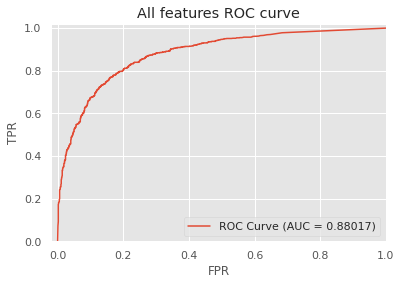

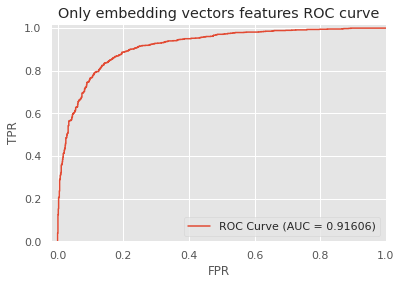

In [67]:
plot_roc_curve(all_features_results, 'All features ROC curve')
plot_roc_curve(only_embedding_feature_results, 'Only embedding vectors features ROC curve')

The conclusion is that embedding vectors are enough informative features for sentiment analysis on our dataset.